<a href="https://colab.research.google.com/github/hursoo/FD_of_MAN/blob/main/jindan_3_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.개요
- 진단학보 논설 파악 위한 특징 추출

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 폴더 경로 지정
file_path = '/content/drive/MyDrive/_JINDAN/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## 런타임 다시 시작 후엔 이 셀 건너뛸 것 !

# =================================================================
# 1단계: 나눔 폰트 설치 (이 셀을 실행한 후, 런타임을 다시 시작해야 합니다)
# =================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (44.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126319 files and direc

In [ ]:
# 필요한 라이브러리 가져오기

import sys
import os, re
import pandas as pd
import numpy as np
import math # math: 수학 계산 함수 모음
import random
import warnings

import matplotlib.pyplot as plt # matplotlib.pyplot: 그래프 생성용, plt로 사용
import matplotlib as mpl # matplotlib: 그래프 스타일 및 설정 변경용, mpl로 사용
import matplotlib.font_manager as fm # matplotlib.font_manager: 그래프 글꼴 관리용, fm으로 사용
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕으로 설정 (Colab 기본 포함) ###
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

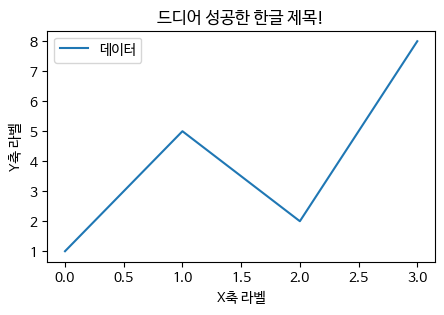

In [ ]:
# --- 이제 그래프를 그려도 경고가 뜨지 않습니다. ---

# 예시 그래프
# (여기에 원래 그리려던 그래프 코드를 넣으시면 됩니다)
plt.figure(figsize=(5, 3))
plt.title('드디어 성공한 한글 제목!')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.plot([1, 5, 2, 8], label='데이터')
plt.legend()
plt.show()

# 2.주요 데이터 불러오기

In [ ]:
# 특정 df 불러오기

feat_df_all = pd.read_excel(file_path + 'result/feat_df_all.xlsx', index_col = 0) # 논설 구분 위한 주요 특성들
print(feat_df_all.shape)
feat_df_all.head()

(59, 9)


,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
GisaId,,,,,,,,,
고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3
고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6
고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8
고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10
김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11


# 3.특성 값 정규화

In [ ]:
# title 제거하고 특성 데이터 열만 남김

features_df = feat_df_all[['f1_divider', 'f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']].copy()
features_df.head()

,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length
GisaId,,,,,,
고유섭(jdh193509),있음,15472,0.165,109.88,130.62,118.88
고유섭(jdh193611),있음,19541,0.065,271.22,178.29,65.74
고유섭(jdh193711),없음,12731,0.175,164.95,199.83,121.14
고유섭(jdh193904),있음,27860,0.108,89.73,144.44,160.96
김두헌(jdh193912),있음,35347,0.212,254.62,99.90,39.23


In [ ]:
# 정규화 진행

import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import io

print("--- 전처리 전 데이터 샘플 ---")
print(features_df.head())
print("\n--- f1_divider 값 분포 ---")
print(features_df['f1_divider'].value_counts())

# 4. 'f1_divider' 순서형 인코딩
# 순서: '없음' < '번호만' < '있음'
# OrdinalEncoder를 사용하여 정의된 순서대로 인코딩합니다.
# categories 매개변수를 사용하여 순서를 지정합니다.
encoder = OrdinalEncoder(categories=[['없음', '번호만', '있음']])
features_df['f1_encoded'] = encoder.fit_transform(features_df[['f1_divider']])

# 원본 'f1_divider' 열은 더 이상 필요 없으므로 제거합니다.
features_df_1 = features_df.drop('f1_divider', axis=1)

# 인코딩 후 데이터 타입 확인
print("\n--- f1 인코딩 후 데이터 샘플 ---")
print(features_df_1.head())

# 5. 수치형 특성 스케일링
# 'f1_encoded'를 제외한 모든 수치형 특성(f2_size, f3_src_size, f4_anno_count, f5_anno_size, f6_anno_length)에 StandardScaler 적용
numeric_features = ['f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']

scaler = StandardScaler()
features_df_1[numeric_features] = scaler.fit_transform(features_df_1[numeric_features])

# 전처리 완료된 데이터프레임 확인
print("\n--- 전처리 완료된 최종 데이터 샘플 (군집화에 사용될 데이터) ---")
print(features_df_1.head())
print("\n--- 전처리 완료된 데이터 통계 ---")
features_df_1.describe()

--- 전처리 전 데이터 샘플 ---
               f1_divider  f2_size  f3_src_size  f4_anno_count  f5_anno_size  \
GisaId                                                                         
고유섭(jdh193509)         있음    15472        0.165         109.88        130.62   
고유섭(jdh193611)         있음    19541        0.065         271.22        178.29   
고유섭(jdh193711)         없음    12731        0.175         164.95        199.83   
고유섭(jdh193904)         있음    27860        0.108          89.73        144.44   
김두헌(jdh193912)         있음    35347        0.212         254.62         99.90   

                f6_anno_length  
GisaId                          
고유섭(jdh193509)          118.88  
고유섭(jdh193611)           65.74  
고유섭(jdh193711)          121.14  
고유섭(jdh193904)          160.96  
김두헌(jdh193912)           39.23  

--- f1_divider 값 분포 ---
f1_divider
있음     42
없음     12
번호만     5
Name: count, dtype: int64

--- f1 인코딩 후 데이터 샘플 ---
                f2_size  f3_src_size  f4_anno_count  f5_anno_size  \
G

,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f1_encoded
count,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,59.000000
mean,9.785016e-17,-1.524204e-16,-7.526936e-18,-2.634428e-17,1.053771e-16,1.508475
std,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,1.008584e+00,0.817331
min,-1.571011e+00,-8.908868e-01,-1.000392e+00,-8.934207e-01,-7.308940e-01,0.000000
25%,-7.920335e-01,-5.347815e-01,-1.000392e+00,-8.934207e-01,-7.308940e-01,1.000000
50%,-1.431849e-01,-3.670294e-01,-1.222442e-01,-4.217858e-01,-3.726322e-01,2.000000
75%,8.447376e-01,1.980303e-01,5.697961e-01,6.850087e-01,3.745664e-01,2.000000
max,2.147104e+00,4.995151e+00,3.121086e+00,2.912174e+00,4.095431e+00,2.000000


In [ ]:
features_df_1.head()

,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f1_encoded
GisaId,,,,,,
고유섭(jdh193509),-0.361572,0.080310,0.115239,0.566066,0.372478,2.0
고유섭(jdh193611),0.056011,-0.508294,1.753352,1.098709,-0.120735,2.0
고유섭(jdh193711),-0.642868,0.139170,0.674374,1.339387,0.393454,0.0
고유섭(jdh193904),0.909751,-0.255195,-0.089348,0.720485,0.763039,2.0
김두헌(jdh193912),1.678106,0.356953,1.584809,0.222815,-0.366785,2.0


# 4.군집화(K-Means)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## 4.1.최적 군집 개수 탐색

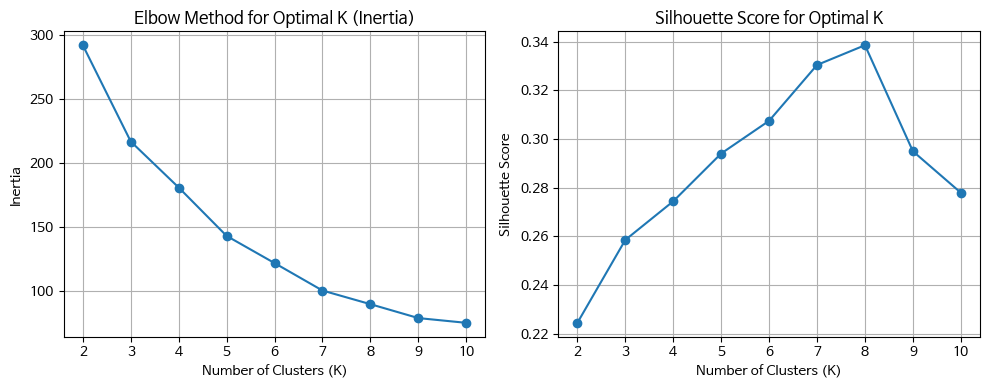


--- K-Means 군집화 결과 요약 ---
K = 2: Inertia = 292.13, Silhouette Score = 0.22
K = 3: Inertia = 216.99, Silhouette Score = 0.26
K = 4: Inertia = 181.11, Silhouette Score = 0.27
K = 5: Inertia = 143.34, Silhouette Score = 0.29
K = 6: Inertia = 122.14, Silhouette Score = 0.31
K = 7: Inertia = 100.72, Silhouette Score = 0.33
K = 8: Inertia = 90.08, Silhouette Score = 0.34
K = 9: Inertia = 79.23, Silhouette Score = 0.30
K = 10: Inertia = 75.51, Silhouette Score = 0.28


In [ ]:
# 5. K-Means 군집화 및 최적 K 탐색
# K 값의 범위 설정 (2개부터 논설의 총 개수-1개까지)
# 일반적으로 K는 총 데이터 개수의 제곱근 근처에서 시작하는 경우가 많지만,
# 여기서는 2부터 10개까지의 K 값을 탐색해 봅시다. (데이터 59개이므로 최대 10개 정도면 충분)
k_range = range(2, 11) # K=2부터 K=10까지 탐색

inertia_values = []
silhouette_scores = []

for k in k_range:
    # KMeans 모델 초기화 및 학습
    # n_init='auto' 또는 명시적인 정수값 (예: 10)을 사용하여 안정적인 결과를 얻습니다.
    # random_state를 설정하여 결과를 재현 가능하게 합니다.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(features_df_1) ###

    # 이너시아(Inertia) 기록
    inertia_values.append(kmeans.inertia_)

    # 실루엣 점수 계산 (군집이 1개일 때는 실루엣 점수를 계산할 수 없으므로 K > 1일 때만 계산)
    if k > 1: # K=1인 경우는 실루엣 점수를 계산할 수 없습니다.
        score = silhouette_score(features_df_1, kmeans.labels_)  ###
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0) # K=1일 경우 0으로 표시 (그래프 일관성 유지)


# 6. 결과 시각화: 엘보우 방법 그래프
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 그래프
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K (Inertia)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)

# 7. 결과 시각화: 실루엣 점수 그래프
# 실루엣 점수 리스트는 k_range와 길이가 다르므로, 2부터 시작하는 k_range에 맞춰 조정
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 그래프
# 실루엣 점수 그래프는 k가 2부터 시작하므로 k_range[1:]과 silhouette_scores[1:]를 사용합니다.
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout() # 그래프들이 겹치지 않도록 조정
plt.show()

# 최적의 K에 대한 추가 정보
print("\n--- K-Means 군집화 결과 요약 ---")
for i, k in enumerate(k_range):
    print(f"K = {k}: Inertia = {inertia_values[i]:.2f}, Silhouette Score = {silhouette_scores[i]:.2f}")


k(군집수) = 8로 결정

In [ ]:
## feat_df_all
feat_df_all.head()

,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol
GisaId,,,,,,,,,
고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3
고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6
고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8
고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10
김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11


In [ ]:
feat_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 고유섭(jdh193509) to 조윤제(jdh194009)
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           59 non-null     object 
 1   f1_divider      59 non-null     object 
 2   f2_size         59 non-null     int64  
 3   f3_src_size     59 non-null     float64
 4   f4_anno_count   59 non-null     float64
 5   f5_anno_size    59 non-null     float64
 6   f6_anno_length  59 non-null     float64
 7   f7_yymm         59 non-null     float64
 8   f8_vol          59 non-null     int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 6.7+ KB


In [ ]:
features_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 고유섭(jdh193509) to 조윤제(jdh194009)
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   f2_size         59 non-null     float64
 1   f3_src_size     59 non-null     float64
 2   f4_anno_count   59 non-null     float64
 3   f5_anno_size    59 non-null     float64
 4   f6_anno_length  59 non-null     float64
 5   f1_encoded      59 non-null     float64
dtypes: float64(6)
memory usage: 5.3+ KB


In [ ]:
!pip install adjustText

## 4.2.군집화 실행

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler # MinMaxScaler 대신 StandardScaler 가정
import matplotlib.pyplot as plt
import io
import re

# numeric_features 리스트는 feat_df_all.info() 및 features_df_1.info()를 기반으로 명시적으로 정의
numeric_features = ['f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']

# --- K-Means 군집화 및 결과 분석 시작 ---

# 5. K-Means 군집화 (최적 K=8 적용)
n_clusters = 8

kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
# 군집화는 features_df_1의 스케일링된 특성들만을 사용.
kmeans_final.fit(features_df_1[numeric_features + ['f1_encoded']])

# 각 논설에 군집 라벨 할당
feat_df_all['cluster_label'] = kmeans_final.labels_
features_df_1['cluster_label'] = kmeans_final.labels_

print(f"\n--- K-Means 군집화 완료: {n_clusters}개의 군집으로 나눔 ---")
print(f"각 군집의 크기:\n{feat_df_all['cluster_label'].value_counts().sort_index()}")

# 6. 각 군집의 특성 분석
print("\n--- 각 군집별 특성 평균 (정규화된 값) ---")
cluster_means = features_df_1.groupby('cluster_label')[numeric_features + ['f1_encoded']].mean()
print(cluster_means)

# 원본 스케일로 되돌려 평균을 보고 싶다면 (역변환)
print("\n--- 각 군집별 특성 평균 (원본 스케일로 역변환) ---")
original_scale_cluster_means = cluster_means.copy()

for i, col in enumerate(numeric_features):
    # StandardScaler의 역변환 공식 사용: X_original = X_scaled * std_dev + mean
    # scaler.scale_는 표준편차(std_dev)를, scaler.mean_은 평균(mean)을 나타냅니다.
    original_scale_cluster_means[col] = cluster_means[col] * scaler.scale_[i] + scaler.mean_[i]

# f1_encoded 역변환 (0 -> 없음, 1 -> 번호만, 2 -> 있음)
f1_categories = encoder.categories_[0]
original_scale_cluster_means['f1_encoded_category'] = original_scale_cluster_means['f1_encoded'].apply(
    lambda x: f1_categories[int(round(x))] if 0 <= round(x) < len(f1_categories) else 'Unknown'
)
original_scale_cluster_means = original_scale_cluster_means.drop('f1_encoded', axis=1)

print(original_scale_cluster_means)

# 7. 각 군집에 속하는 논설 제목 일부 출력
print("\n--- 각 군집별 논설 제목 샘플 ---")
for i in range(n_clusters):
    cluster_n_papers = feat_df_all[feat_df_all['cluster_label'] == i]
    print(f"\n--- 군집 {i} ({len(cluster_n_papers)}편) ---")
    for j, row in cluster_n_papers.head(5).iterrows():
        # df에 'Title' 열이 명확히 존재하므로 'Title' 열에 직접 접근합니다.
        print(f"- {row['Title']}")


--- K-Means 군집화 완료: 8개의 군집으로 나눔 ---
각 군집의 크기:
cluster_label
0     5
1    18
2    12
3    11
4     1
5     7
6     2
7     3
Name: count, dtype: int64

--- 각 군집별 특성 평균 (정규화된 값) ---
                f2_size  f3_src_size  f4_anno_count  f5_anno_size  \
cluster_label                                                       
0              0.190491     1.710742      -0.112660     -0.450435   
1              0.351429    -0.570098      -0.321686     -0.682111   
2              0.621502    -0.217916      -0.014544      1.033381   
3             -1.157916    -0.119816      -0.881462     -0.800894   
4             -1.571011     4.995151       1.202643      2.079522   
5              0.070129    -0.161859       1.872884      1.117959   
6             -0.778897     0.477617      -0.867792     -0.182449   
7              0.212925     0.274549       1.215673      0.466361   

               f6_anno_length  f1_encoded  
cluster_label                              
0                   -0.358339    2.00000

## 4.3.군집결과 시각화(t-SNE)


--- 군집 시각화 시작 (t-SNE를 이용한 2D 플롯, adjustText 적용) ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


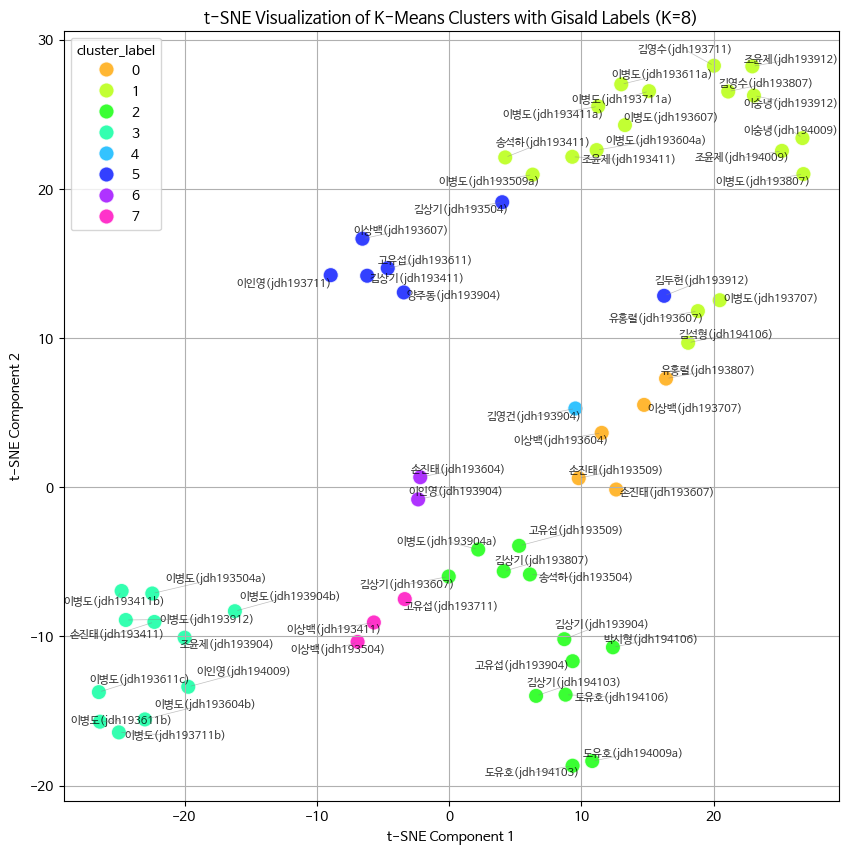


--- 군집 시각화 (adjustText 적용) 완료 ---


In [ ]:

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# adjustText 라이브러리 임포트 (설치되어 있어야 함)
from adjustText import adjust_text

# K-Means 군집화에 필요한 numeric_features 리스트는 명시적으로 정의합니다.
numeric_features = ['f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']

# --- 군집 시각화 (t-SNE 사용, adjustText로 라벨 겹침 조정) ---

print("\n--- 군집 시각화 시작 (t-SNE를 이용한 2D 플롯, adjustText 적용) ---")

tsne = TSNE(n_components=2, perplexity=min(5, len(features_df_1)-1), random_state=42, n_iter=2500, learning_rate='auto')

# 군집화에 사용된 특성 데이터(f1_encoded 포함)만 사용하여 t-SNE 적용
tsne_results = tsne.fit_transform(features_df_1[numeric_features + ['f1_encoded']])

# t-SNE 결과를 데이터프레임으로 변환
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne_1', 'tsne_2'])

# t-SNE 결과에 군집 라벨 추가
tsne_df['cluster_label'] = features_df_1['cluster_label'].values

# feat_df_all의 GisaId와 Title을 tsne_df에 병합
feat_df_all_1 = feat_df_all.reset_index(drop=False) # GisaId 인덱스 해제
tsne_df = pd.merge(tsne_df, feat_df_all_1[['GisaId', 'Title']], left_index=True, right_index=True)
tsne_df['GisaId'] = feat_df_all_1['GisaId'].values
tsne_df['Title'] = feat_df_all_1['Title'].values


# 시각화 기본 플롯
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='cluster_label',
    palette=sns.color_palette("hsv", n_colors=n_clusters),
    data=tsne_df,
    legend='full',
    alpha=0.8,
    s=120 # 점 크기 유지
)

plt.title('t-SNE Visualization of K-Means Clusters with GisaId Labels (K={})'.format(n_clusters))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)

# 텍스트 라벨 객체들을 저장할 리스트
texts = []

# 각 점 옆에 GisaId 라벨 출력 (adjustText에 전달하기 위해 텍스트 객체 생성)
for i in range(len(tsne_df)):
    # 점의 중앙에 가까운 위치에 텍스트를 배치한 후 adjust_text가 조정하도록 합니다.
    texts.append(plt.text(
        tsne_df['tsne_1'][i],
        tsne_df['tsne_2'][i],
        tsne_df['GisaId'][i], # GisaId를 라벨로 사용
        fontsize=8,
        alpha=0.8,
        ha='center', # 가로 정렬: 중앙
        va='center'  # 세로 정렬: 중앙
    ))

# adjust_text 함수를 사용하여 텍스트 라벨 겹침 조정
# arrowprops는 텍스트와 점을 연결하는 화살표를 그릴 때 사용 (선택 사항)
adjust_text(texts,
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5), # 화살표 추가 (선택 사항)
            force_points=(0.2, 0.2), # 라벨이 점으로부터 밀려나는 힘 (x,y)
            force_text=(0.5, 0.5),   # 라벨이 라벨로부터 밀려나는 힘 (x,y)
            expand_points=(1.5, 1.5), # 라벨이 점과 라벨 주변으로 확장되는 비율
            expand_text=(1.5, 1.5)    # 텍스트끼리 밀어내는 간격
           )

plt.show()

print("\n--- 군집 시각화 (adjustText 적용) 완료 ---")

In [ ]:
# 각 군집별 특성 평균

original_scale_cluster_means

,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f1_encoded_category
cluster_label,,,,,,
0,20851.400000,0.442000,87.434000,39.646000,40.140000,있음
1,22419.611111,0.054500,66.846667,18.911667,17.930000,있음
2,25051.250000,0.114333,97.097500,172.443333,188.930833,있음
3,7712.272727,0.131000,11.713636,8.280909,11.295455,없음
4,3687.000000,1.000000,216.980000,266.070000,122.620000,없음
5,19678.571429,0.123857,282.992857,180.012857,64.172857,있음
6,11405.500000,0.232500,13.060000,63.630000,486.500000,번호만
7,21070.000000,0.198000,218.263333,121.696667,62.153333,없음


## 4.4.군집별 논설 제목 출력

In [ ]:
feat_df_all_1.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label
0,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3,2
1,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6,5
2,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8,7
3,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10,2
4,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11,5


In [ ]:
# 저장될 텍스트 파일 이름 설정
output_filename = file_path + 'result/cluster_paper_titles.txt'

print(f"\n--- 각 군집별 논설 제목을 '{output_filename}' 파일로 저장 중 ---")

# 파일 열기 (쓰기 모드 'w', 인코딩은 'utf-8'로 한글 깨짐 방지)
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write("=== 각 군집별 진단학보 논설 제목 ===\n\n")

    # 각 군집을 순회하며 제목을 파일에 씁니다.
    for i in range(n_clusters):
        # 현재 군집에 속하는 논설들을 필터링
        cluster_n_papers = feat_df_all_1[feat_df_all_1['cluster_label'] == i]

        # 군집 정보 (번호 및 논설 개수)를 파일에 씁니다.
        f.write(f"--- 군집 {i} ({len(cluster_n_papers)}편) ---\n")

        # 해당 군집의 모든 논설 제목을 파일에 씁니다.
        for j, row in cluster_n_papers.iterrows():
            f.write(f"- {row['GisaId']}, {row['Title']}\n") # 'GisaId', 'Title' 열의 내용을 씁니다.

        f.write("\n") # 각 군집 사이에 빈 줄을 넣어 구분합니다.

print(f"'{output_filename}' 파일 저장 완료. 파일을 열어 내용을 확인해주세요.")



--- 각 군집별 논설 제목을 '/content/drive/MyDrive/_JINDAN/result/cluster_paper_titles.txt' 파일로 저장 중 ---
'/content/drive/MyDrive/_JINDAN/result/cluster_paper_titles.txt' 파일 저장 완료. 파일을 열어 내용을 확인해주세요.


In [ ]:
# 군집화 레이블 반영된 것 확인
feat_df_all_1.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label
0,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3,2
1,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6,5
2,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8,7
3,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10,2
4,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11,5


# 5.군집별 특징 분석

## 5.1.군집별 특성 기여도
- 군집화에 어떤 특성이 많은 영향을 끼쳤는가를 파악


--- 특성 기여도 분석 시작 (의사결정나무) ---

--- 각 특성의 군집 구분 기여도 (Feature Importance) ---
          Feature  Importance
4  f6_anno_length    0.275995
5      f1_encoded    0.225548
2   f4_anno_count    0.187421
1     f3_src_size    0.164672
0         f2_size    0.146365
3    f5_anno_size    0.000000


/tmp/ipython-input-37-2914308249.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


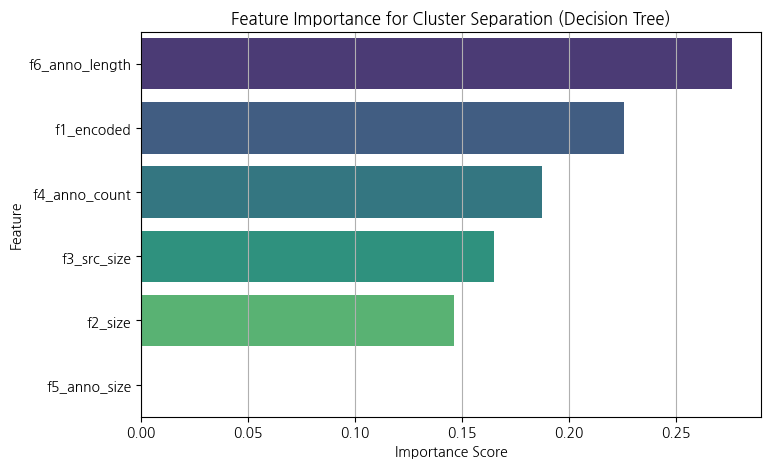


--- 특성 기여도 분석 완료 ---


In [ ]:
# 특성 기여도 분석 (의사결정나무 사용)

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # 의사결정나무 분류기 임포트

print("\n--- 특성 기여도 분석 시작 (의사결정나무) ---")

# 1. 피처(X)와 타겟(y) 데이터 준비
# features_df_1에서 'cluster_label' 열을 제외한 모든 특성들을 X로 사용합니다.
# numeric_features 리스트는 이미 위에서 정의되었으므로 그대로 사용합니다.
X = features_df_1[numeric_features + ['f1_encoded']]

# y (타겟): 의사결정나무가 예측해야 할 '정답'. K-Means 군집화 결과인 'cluster_label' 열입니다.
y = features_df_1['cluster_label']

# 2. 의사결정나무 분류기 모델 초기화 및 학습
# random_state를 설정하여 모델 학습 결과가 매번 동일하도록 합니다 (재현성).
# max_depth=5는 나무의 깊이를 5단계로 제한하여 너무 복잡해지는 것을 막습니다 (선택 사항).
# 데이터의 복잡성에 따라 이 값을 조절할 수 있습니다.
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_classifier.fit(X, y)

# 3. 특성 중요도 추출
# 학습된 모델이 각 특성에 부여한 중요도 점수 (0에서 1 사이, 합계 1)
feature_importances = dt_classifier.feature_importances_

# 4. 특성 중요도를 데이터프레임으로 정리하여 출력
feature_names = X.columns.tolist() # X 데이터프레임의 열 이름이 곧 특성 이름입니다.

# 특성 이름과 중요도 점수를 매핑하여 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도가 높은 순서로 정렬하여 보기 쉽게 합니다.
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\n--- 각 특성의 군집 구분 기여도 (Feature Importance) ---")
print(importance_df)

# 5. 특성 중요도 시각화
plt.figure(figsize=(8, 5)) # 그래프 크기 설정
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Cluster Separation (Decision Tree)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x') # x축에 그리드 라인 추가
plt.show()

print("\n--- 특성 기여도 분석 완료 ---")

## 5.2.주요 특성으로 본 군집별 특징

In [ ]:
# 군집화 기본 입력 자료 불러오기
features_df_1.head()

,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f1_encoded,cluster_label
GisaId,,,,,,,
고유섭(jdh193509),-0.361572,0.080310,0.115239,0.566066,0.372478,2.0,2
고유섭(jdh193611),0.056011,-0.508294,1.753352,1.098709,-0.120735,2.0,5
고유섭(jdh193711),-0.642868,0.139170,0.674374,1.339387,0.393454,0.0,7
고유섭(jdh193904),0.909751,-0.255195,-0.089348,0.720485,0.763039,2.0,2
김두헌(jdh193912),1.678106,0.356953,1.584809,0.222815,-0.366785,2.0,5


In [ ]:
col_name = features_df_1.columns.tolist()[5:6] + features_df_1.columns.tolist()[:5]
print(col_name)

['f1_encoded', 'f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']


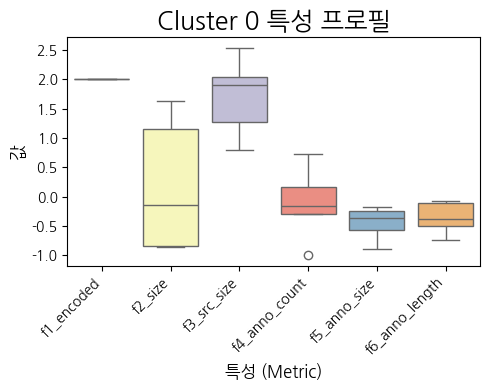

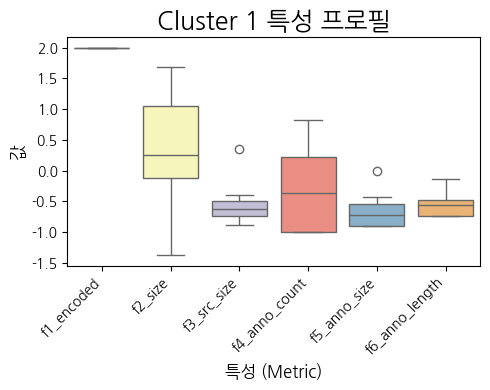

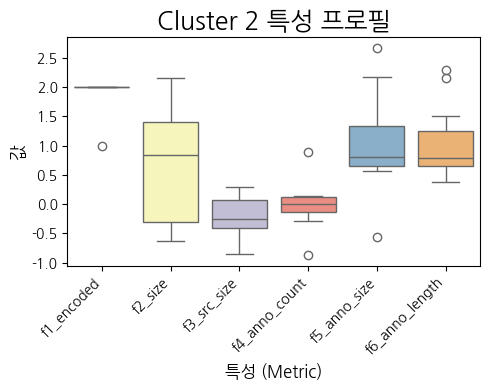

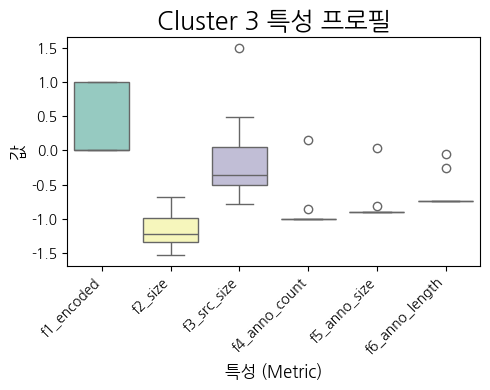

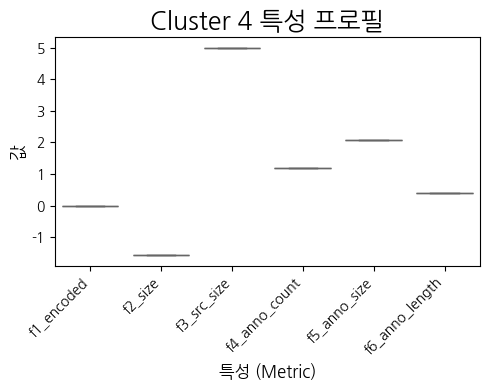

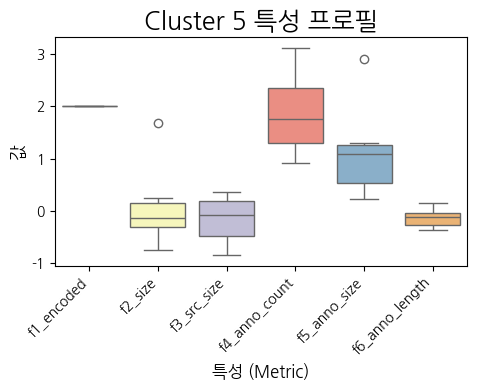

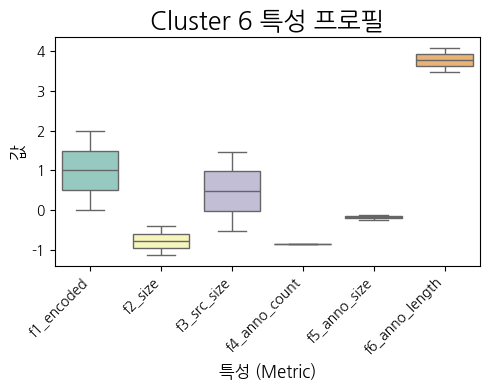

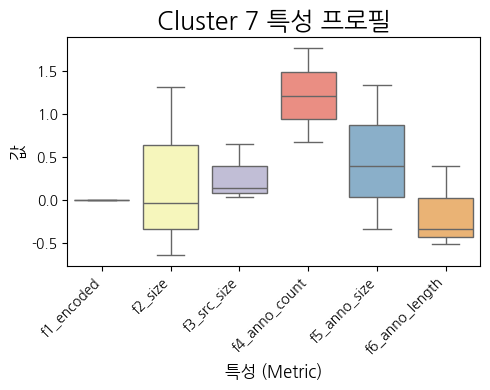

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정 (기존 코드와 동일)
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
else: # Linux
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 1. 시각화를 위해 'wide' 포맷에서 'long' 포맷으로 데이터 재구성 (기존 코드와 동일)
df_melted = features_df_1.melt(id_vars=['cluster_label'],
                               value_vars=['f1_encoded', 'f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length'],
                               var_name='metric',
                               value_name='value')

# ✨ 수정된 부분: for 루프를 사용하여 클러스터별로 플롯을 순차적으로 생성합니다.
# 모든 클러스터의 고유한 ID를 가져옵니다.
cluster_ids = sorted(df_melted['cluster_label'].unique())

# 각 클러스터 ID에 대해 반복합니다.
for cluster_id in cluster_ids:
    # 2. 새 Figure 객체를 생성하여 각 플롯이 독립적으로 그려지도록 합니다.
    plt.figure(figsize=(5, 4))

    # 3. 현재 클러스터에 해당하는 데이터만 필터링합니다.
    cluster_data = df_melted[df_melted['cluster_label'] == cluster_id]

    # 4. 필터링된 데이터로 박스플롯을 생성합니다.
    sns.boxplot(data=cluster_data, x='metric', y='value', palette='Set3', hue='metric')

    # 5. 제목 및 레이블을 설정합니다.
    plt.title(f'Cluster {cluster_id} 특성 프로필', fontsize=18)
    plt.xlabel('특성 (Metric)', fontsize=12)
    plt.ylabel('값', fontsize=12)

    # x축 틱 레이블을 읽기 쉽게 45도 회전시킵니다.
    plt.xticks(rotation=45, ha='right')

    # 범례는 x축 레이블과 내용이 중복되므로 제거합니다.
    plt.legend([],[], frameon=False)

    # 레이아웃을 조정하여 제목이나 레이블이 잘리지 않도록 합니다.
    plt.tight_layout()

    # 6. 완성된 플롯을 화면에 표시합니다. 이 창을 닫으면 다음 루프가 실행됩니다.
    plt.show()

## 5.3.주요 군집과 주요 필자의 관계
- 주요 군집: 1,2,3
- 주요 필자: 59편 중 3편 이상 집필자

In [ ]:
feat_df_all_1.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label
0,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3,2
1,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6,5
2,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8,7
3,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10,2
4,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11,5


In [ ]:
# 필자별 논설 수

feat_df_all_1['writer'] = feat_df_all_1['GisaId'].apply(lambda x:x[:3])
writer = feat_df_all_1.groupby('writer').agg('count').sort_values('GisaId', ascending=False)
big_writer = writer.query('GisaId > 2')
big_writer

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label
writer,,,,,,,,,,,
이병도,17,17,17,17,17,17,17,17,17,17,17
김상기,6,6,6,6,6,6,6,6,6,6,6
이상백,5,5,5,5,5,5,5,5,5,5,5
고유섭,4,4,4,4,4,4,4,4,4,4,4
손진태,4,4,4,4,4,4,4,4,4,4,4
조윤제,4,4,4,4,4,4,4,4,4,4,4
이인영,3,3,3,3,3,3,3,3,3,3,3
도유호,3,3,3,3,3,3,3,3,3,3,3


In [ ]:
#
feat_df_all_1.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label,writer
0,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3,2,고유섭
1,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6,5,고유섭
2,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8,7,고유섭
3,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10,2,고유섭
4,김두헌(jdh193912),朝鮮妾制史小考,있음,35347,0.212,254.62,99.90,39.23,1939.12,11,5,김두헌


In [ ]:

writer_cls = feat_df_all_1[feat_df_all_1['writer'].isin(big_writer.index)]
writer_cls.head()

,GisaId,Title,f1_divider,f2_size,f3_src_size,f4_anno_count,f5_anno_size,f6_anno_length,f7_yymm,f8_vol,cluster_label,writer
0,고유섭(jdh193509),高麗畵跡 對하야,있음,15472,0.165,109.88,130.62,118.88,1935.09,3,2,고유섭
1,고유섭(jdh193611),朝鮮塔婆의 研究,있음,19541,0.065,271.22,178.29,65.74,1936.11,6,5,고유섭
2,고유섭(jdh193711),佛敎가 高麗藝術 意欲에 끼친 影響의 一考察,없음,12731,0.175,164.95,199.83,121.14,1937.11,8,7,고유섭
3,고유섭(jdh193904),朝鮮塔婆 研究 (2),있음,27860,0.108,89.73,144.44,160.96,1939.04,10,2,고유섭
5,김상기(jdh193411),古代의 貿易形態와 羅末의 海上發展에 就하야 (一)-淸海鎭大使張保皐를 主로 하야-,있음,15484,0.074,297.08,196.01,65.98,1934.11,1,5,김상기


In [ ]:
import pandas as pd

pivot_df = writer_cls.pivot_table(index='writer', columns='cluster_label', values='GisaId', aggfunc=list)
pivot_df.to_excel(file_path + 'result/writer_cluster.xlsx')

In [ ]:
writer_cls.columns

Index(['GisaId', 'Title', 'f1_divider', 'f2_size', 'f3_src_size',
       'f4_anno_count', 'f5_anno_size', 'f6_anno_length', 'f7_yymm', 'f8_vol',
       'cluster_label', 'writer'],
      dtype='object')

## 5.4.시기별 변화


--- 시기별 경향성 분석 시작 ---

--- 시기 구분 완료: 1937.07을 기준으로 초기/후기 분할 ---
period
Early (1934-1937.7)    26
Late (1937.8-1941)     20
Name: count, dtype: int64

--- 시기별 군집 분포 (비율) ---
cluster_label                0          1          2          3          5  \
period                                                                       
Early (1934-1937.7)  15.384615  26.923077   7.692308  23.076923  15.384615   
Late (1937.8-1941)    0.000000  20.000000  40.000000  25.000000   5.000000   

cluster_label               6         7  
period                                   
Early (1934-1937.7)  3.846154  7.692308  
Late (1937.8-1941)   5.000000  5.000000  


/tmp/ipython-input-50-3363245716.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f6_anno_length'] = pd.to_numeric(df['f6_anno_length'], errors='coerce')
/tmp/ipython-input-50-3363245716.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f6_anno_length'] = df['f6_anno_length'].fillna(0.0) # NaN 값 처리 (예: 0으로 채움)
/tmp/ipython-input-50-3363245716.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

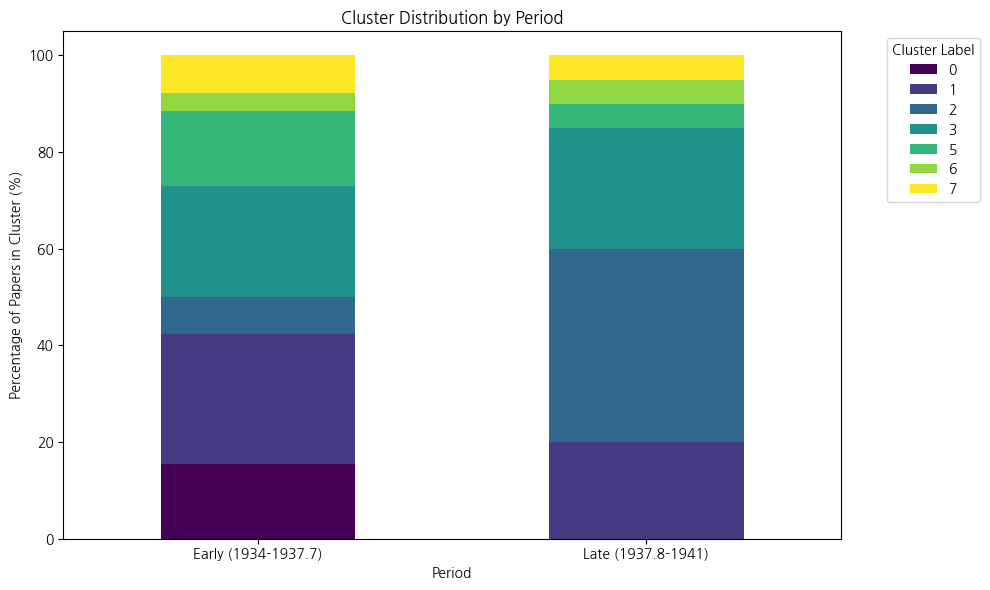


--- 시기별 특성 평균 변화 (원본 스케일) ---
                          f2_size  f3_src_size  f4_anno_count  f5_anno_size  \
period                                                                        
Early (1934-1937.7)  15912.730769     0.166269     109.551538     59.015385   
Late (1937.8-1941)   20009.550000     0.112650      79.222000    114.101000   

                     f6_anno_length  f1_divider_encoded_temp  
period                                                        
Early (1934-1937.7)       57.178077                 1.461538  
Late (1937.8-1941)       120.307500                 1.350000  


/tmp/ipython-input-50-3363245716.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['f1_divider_encoded_temp'] = encoder.transform(df[['f1_divider']])


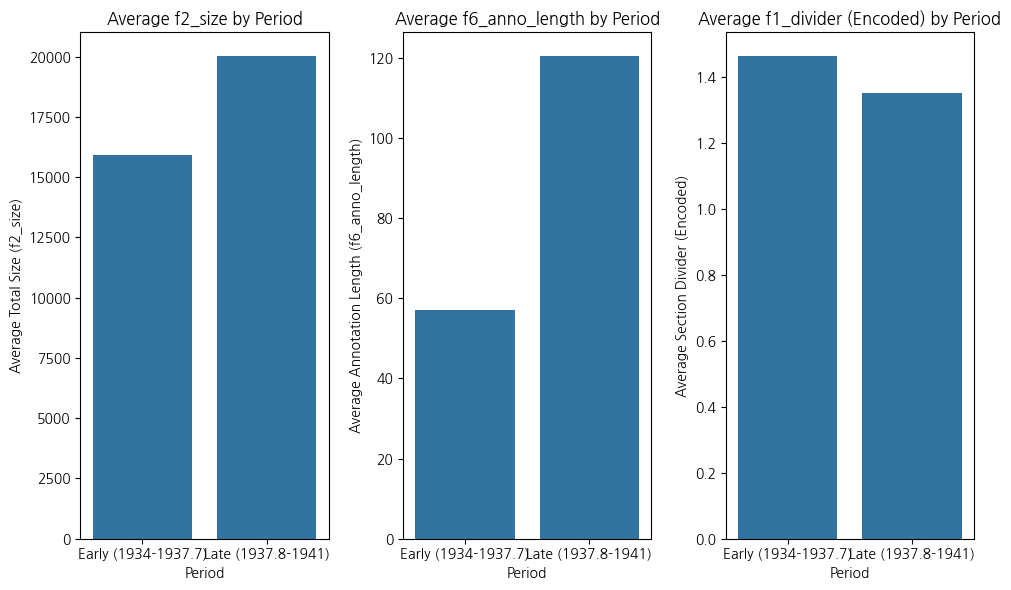


--- 시기별 경향성 분석 완료 ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 시각화 라이브러리

def periodic_change(df):
    # 1. df: 원본 논설 제목 ('Title' 열), 'f7_yymm' (발행 연월), 'cluster_label', 'f6_anno_length' (object) 등을 포함한 데이터프레임
    # 2. n_clusters: K-Means 군집 개수 (현재 8)
    # 3. numeric_features: 수치형 특성 열 이름 리스트 (예: ['f2_size', 'f3_src_size', ...])
    # 4. encoder: f1_divider를 인코딩하는 데 사용되었던 OrdinalEncoder 객체 (학습된 상태)
    # 5. scaler: features_df_1을 스케일링하는 데 사용되었던 StandardScaler 객체 (학습된 상태)

    # numeric_features 리스트는 이전 단계에서 정의되었으므로 다시 정의할 필요는 없지만,
    # 이 코드 블록에서 사용하기 위해 명시적으로 가져옵니다.
    numeric_features = ['f2_size', 'f3_src_size', 'f4_anno_count', 'f5_anno_size', 'f6_anno_length']


    # --- 1934-1941 시기별 경향성 분석 ---

    print("\n--- 시기별 경향성 분석 시작 ---")

    # ===> 수정된 부분: f6_anno_length를 float으로 변환 <===
    # f6_anno_length 열에 숫자로 변환 불가능한 값이 있을 경우를 대비하여 errors='coerce' 사용
    # 이는 변환 실패 시 NaN으로 만들고, 이후 fillna(0.0)으로 처리합니다.
    df['f6_anno_length'] = pd.to_numeric(df['f6_anno_length'], errors='coerce')
    df['f6_anno_length'] = df['f6_anno_length'].fillna(0.0) # NaN 값 처리 (예: 0으로 채움)

    # 1. 시기 구분 기준 설정
    split_year_month = 1937.07

    # 'period' 열 생성 (초기 또는 후기)
    df['period'] = df['f7_yymm'].apply(lambda x: 'Early (1934-1937.7)' if x <= split_year_month else 'Late (1937.8-1941)')

    print(f"\n--- 시기 구분 완료: {split_year_month}을 기준으로 초기/후기 분할 ---")
    print(df['period'].value_counts())

    # 2. 시기별 군집 분포 분석
    print("\n--- 시기별 군집 분포 (비율) ---")
    period_cluster_distribution = pd.crosstab(df['period'], df['cluster_label'], normalize='index') * 100
    print(period_cluster_distribution)

    # 시각화: 시기별 군집 분포 막대 그래프
    period_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')
    plt.title('Cluster Distribution by Period')
    plt.xlabel('Period')
    plt.ylabel('Percentage of Papers in Cluster (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 3. 시기별 특성 평균 변화 분석
    print("\n--- 시기별 특성 평균 변화 (원본 스케일) ---")

    # 'f1_divider'를 수치형으로 변환 (이 분석 내에서만 임시 사용)
    # 이전에 encoder가 학습되었으므로, encoder를 사용하여 변환합니다.
    df['f1_divider_encoded_temp'] = encoder.transform(df[['f1_divider']])

    # 분석할 특성들 (numeric_features와 f1_divider_encoded_temp 포함)
    # f6_anno_length는 이제 numeric_features에 포함되어 있고 float으로 변환되었으므로 그대로 사용합니다.
    analysis_features = numeric_features + ['f1_divider_encoded_temp']

    # 시기별 특성 평균 계산
    period_feature_means = df.groupby('period')[analysis_features].mean()
    print(period_feature_means)

    # 시각화: 시기별 주요 특성 변화
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1) # 1행 3열 중 첫 번째
    sns.barplot(x='period', y='f2_size', data=df, errorbar=None)
    plt.title('Average f2_size by Period')
    plt.xlabel('Period')
    plt.ylabel('Average Total Size (f2_size)')

    plt.subplot(1, 3, 2) # 1행 3열 중 두 번째
    sns.barplot(x='period', y='f6_anno_length', data=df, errorbar=None)
    plt.title('Average f6_anno_length by Period')
    plt.xlabel('Period')
    plt.ylabel('Average Annotation Length (f6_anno_length)')

    plt.subplot(1, 3, 3) # 1행 3열 중 세 번째
    sns.barplot(x='period', y='f1_divider_encoded_temp', data=df, errorbar=None)
    plt.title('Average f1_divider (Encoded) by Period')
    plt.xlabel('Period')
    plt.ylabel('Average Section Divider (Encoded)')
    plt.tight_layout()
    plt.show()

    print("\n--- 시기별 경향성 분석 완료 ---")

periodic_change(writer_cls)

# The End of Note